
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## STORM database. Extraction of TC affecting the study area and MDA selection

input required:
   * The 10,000 year TC STORM dataset https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d
   * The historical TCs from Ibtracks ***notebook 05***
    
in this notebook:
   * read STORM database
   * plot historical and synthetic TCs affecting the study site
   * parameterization of TCs
   * MDA selection and plotting

In [1]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import glob
import pandas as pd

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.storms import Extract_Circle_STORM
from teslakit.mda import MaxDiss_Simplified_NoThreshold
from teslakit.plotting.storms import Plot_TCs_STORMSbase_Tracks, Plot_TCs_Params_STORM_MDAvsSIM, \
    Plot_TCs_Params_HISTvsSIM, Plot_TCs_Params_HISTvsSIM_histogram


## Database and Site parameters

In [2]:

p_data = r'/Users/anacrueda/Documents/Proyectos/TESLA/data' 
p_data_temp = r'/Users/anacrueda/Documents/Data/STORMs/data'

db = Database(p_data)

# set site
db.SetSite('ROI')

# choose the basin
basin = 'WP' # EP: Eastern Pacific, NA: North Atlantic, NI: North Indian, 
             # SI: South Indian, SP: South Pacific, WP: Western Pacific

# wave point longitude and latitude ROI
pnt_lon = 167.5
pnt_lat = 9.75

# radius for TCs selection (º)
r1 = 14
r2 = 4


## STORM database

In [3]:
# load data and set parameters

# read STORM database
path = os.path.join(p_data_temp, "STORM_DATA_IBTRACS_{}*.txt".format(basin))
file_list = sorted(glob.glob(path))

tc_list = []
cont = 0
for file in file_list:
    df = pd.read_table(file,
                       sep = ',',
                       header = None,
                       names=('year', 'month', 'storm', 'TimeStep', 'Basin', 'lat', 'lon', 'pressure_min','windspeed_max','rmax','cat','land','dist_land'),
                       dtype={'year': np.float64,
                              'month': np.float64,
                              'storm': np.float64,
                              'TimeStep': np.float64,
                              'basin': np.int64,
                              'lat': np.float64,
                              'lon': np.float64,
                              'pressure_min': np.float64,
                              'windspeed_max': np.float64,
                              'rmax': np.float64,
                              'cat': np.int64,
                              'land': np.float64,
                              'dist_land': np.float64})

    #modify storm column to know how many ciclones per simulation
    for i in df['year'].unique():
        if i == 0: continue
        late_storm = np.nanmax(df.loc[df.year == i-1, ['storm']])
        #print(late_storm)
        df.loc[df.year == i, ['storm']] = df.loc[df.year == i, ['storm']] + late_storm

    if cont > 0:
        last_storm = storms[-1]
        #print('last_storm')
        #print(last_storm)
        df['storm'] = df['storm']+last_storm
    df.set_index('storm', inplace=True)
    # store DataFrame in list
    tc_list.append(df)
    storms = df.index.tolist()
    cont = cont + 1

tc_list = pd.concat(tc_list)

tc_storms = tc_list.to_xarray()

print(tc_storms)

<xarray.Dataset>
Dimensions:        (storm: 8911561)
Coordinates:
  * storm          (storm) float64 0.0 0.0 0.0 ... 2.153e+05 2.153e+05 2.153e+05
Data variables:
    year           (storm) float64 0.0 0.0 0.0 0.0 ... 999.0 999.0 999.0 999.0
    month          (storm) float64 9.0 9.0 9.0 9.0 9.0 ... 8.0 8.0 8.0 8.0 8.0
    TimeStep       (storm) float64 0.0 1.0 2.0 3.0 4.0 ... 3.0 4.0 5.0 6.0 7.0
    Basin          (storm) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
    lat            (storm) float64 15.6 15.8 16.1 16.4 ... 15.8 16.3 16.8 17.3
    lon            (storm) float64 136.8 136.5 136.2 135.9 ... 122.0 121.9 121.9
    pressure_min   (storm) float64 993.4 989.1 986.6 986.6 ... 991.8 991.8 993.6
    windspeed_max  (storm) float64 18.01 20.8 22.4 22.3 ... 19.1 19.08 17.75
    rmax           (storm) float64 46.3 45.91 45.53 45.14 ... 67.91 89.51 111.1
    cat            (storm) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 -1 0 0 0 0 0 0 0 -1
    land           (storm) float64 0.0 0.0

In [4]:
# Get STORMS TCs at the study area
# dictionary with needed variable names
d_vns = {
    'longitude':'lon',
    'latitude':'lat',
    'time': 'TimeStep',
    'pressure':'pressure_min',
    'radius':'rmax',
    'mwinds': 'windspeed_max',
}

# Extract STORMS TCs inside r2
TCs_r2_sim_tracks, TCs_r2_sim_params = Extract_Circle_STORM(tc_storms, pnt_lon, pnt_lat, r2, d_vns)
print(TCs_r2_sim_params)

# Store STORMS TCs parameters
db.Save_TCs_r2_sim_params(TCs_r2_sim_params)


<xarray.Dataset>
Dimensions:        (storm: 3296)
Coordinates:
  * storm          (storm) int64 2 19 45 63 71 ... 215077 215100 215224 215244
Data variables:
    pressure_min   (storm) float64 974.8 941.8 963.3 996.5 ... 987.7 895.4 985.5
    pressure_mean  (storm) float64 980.2 953.2 976.3 996.6 ... 991.8 903.0 989.2
    velocity_mean  (storm) float64 19.31 30.99 16.07 21.17 ... 25.62 13.54 44.81
    winds_mean     (storm) float64 28.63 33.26 26.72 20.4 ... 22.7 27.88 24.2
    mean_radius    (storm) float64 43.21 44.18 43.98 45.91 ... 45.14 46.49 44.76
    gamma          (storm) float64 157.2 119.1 131.3 121.5 ... 93.73 180.0 102.8
    delta          (storm) float64 180.7 95.87 98.79 90.39 ... 51.76 241.2 83.08
    category       (storm) int64 2 4 3 1 1 1 4 2 3 2 5 ... 1 1 1 1 2 4 2 1 1 5 1
    dmin_date      (storm) float64 9.0 11.0 6.0 0.0 8.0 ... 8.0 7.0 3.0 86.0 4.0
    index_in       (storm) int64 1 7 0 0 4 3 5 0 0 3 ... 0 0 0 47 5 6 0 0 74 1
    index_out      (storm) int64 15 1

In [5]:
# Plot storm tracks world map (requires basemap)

lon1, lon2 = 90, 270
lat1, lat2 = -20, 70

Plot_TCs_STORMSbase_Tracks(
    TCs_r2_sim_tracks,
    lon1, lon2, lat1, lat2,
    pnt_lon, pnt_lat,  r2,
)


basemap module required.


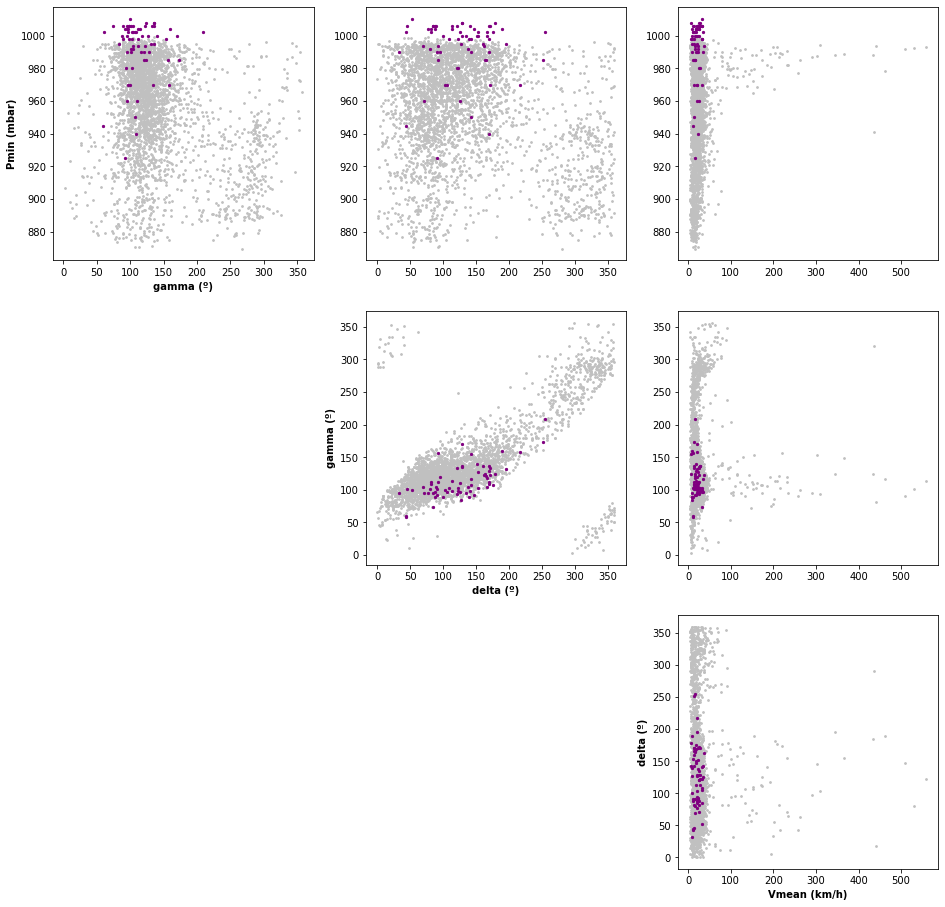

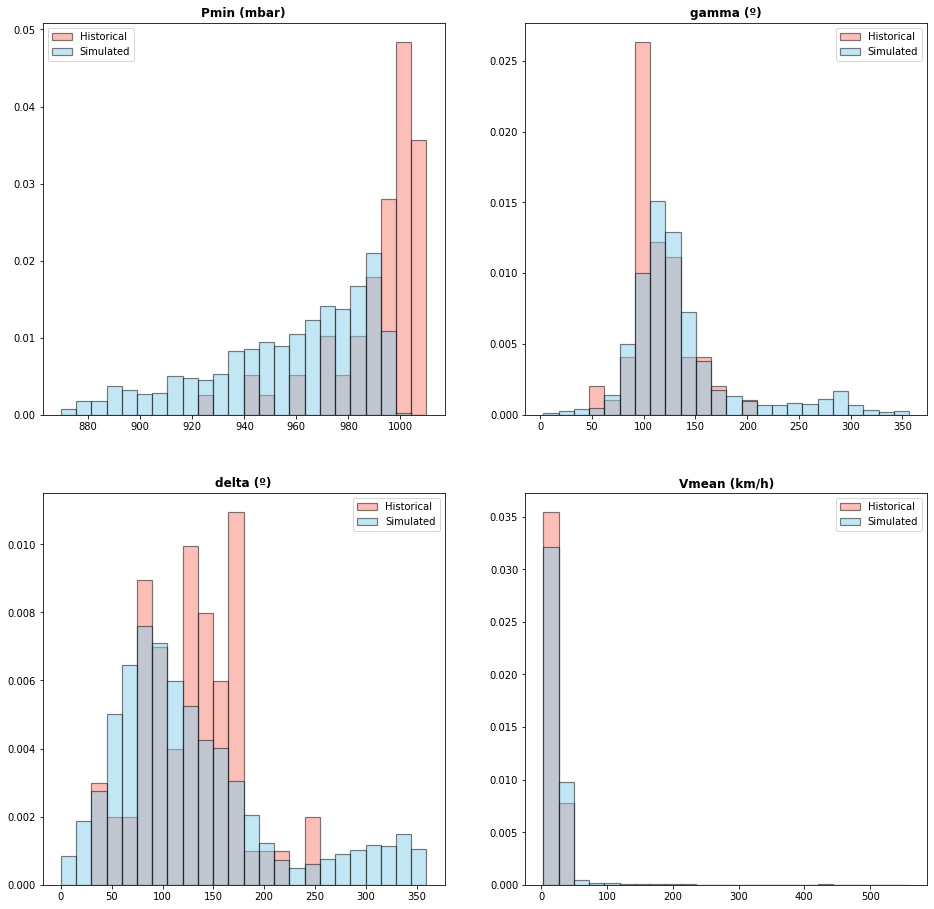

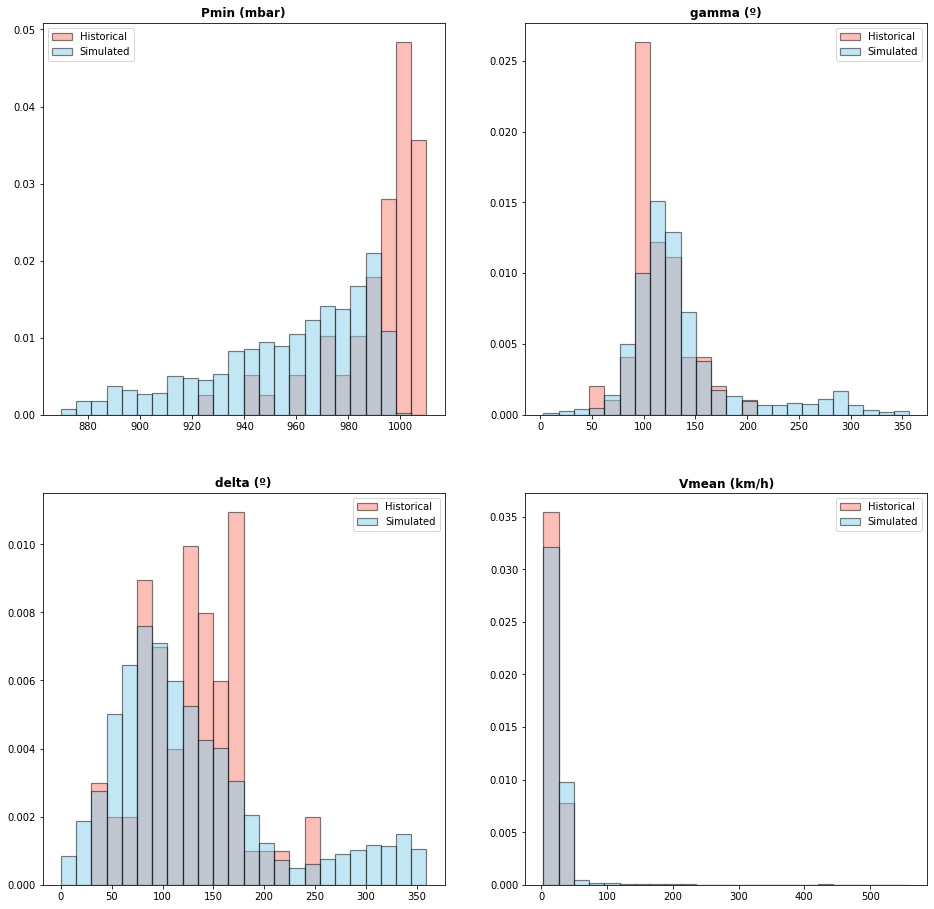

In [3]:
## check STORMs TCs vs. historical

#TCs_r2_sim_params = db.Load_TCs_r2_sim_params()

# Historical vs STORM parameters:
_, TCs_r2_hist_params = db.Load_TCs_r2_hist()  # historical TCs parameters inside radius 2

# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params)

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params)



## MDA selection


MaxDiss waves parameters: 3296 --> 400

   MDA centroids: 400/400

<xarray.Dataset>
Dimensions:        (storm: 400)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Data variables:
    pressure_mean  (storm) float64 1e+03 899.2 897.3 934.0 ... 945.6 969.6 974.7
    pressure_min   (storm) float64 995.1 869.5 891.0 923.1 ... 938.6 949.1 959.9
    velocity_mean  (storm) float64 21.01 16.7 8.086 32.92 ... 10.99 19.63 19.85
    mean_radius    (storm) float64 44.18 51.55 34.53 128.5 ... 51.42 43.02 45.72
    winds_mean     (storm) float64 25.9 25.69 47.5 18.82 ... 22.11 29.32 20.88
    delta          (storm) float64 78.69 279.8 60.09 48.51 ... 351.2 162.8 119.9
    gamma          (storm) float64 89.95 267.4 106.5 10.68 ... 59.63 201.2 143.0


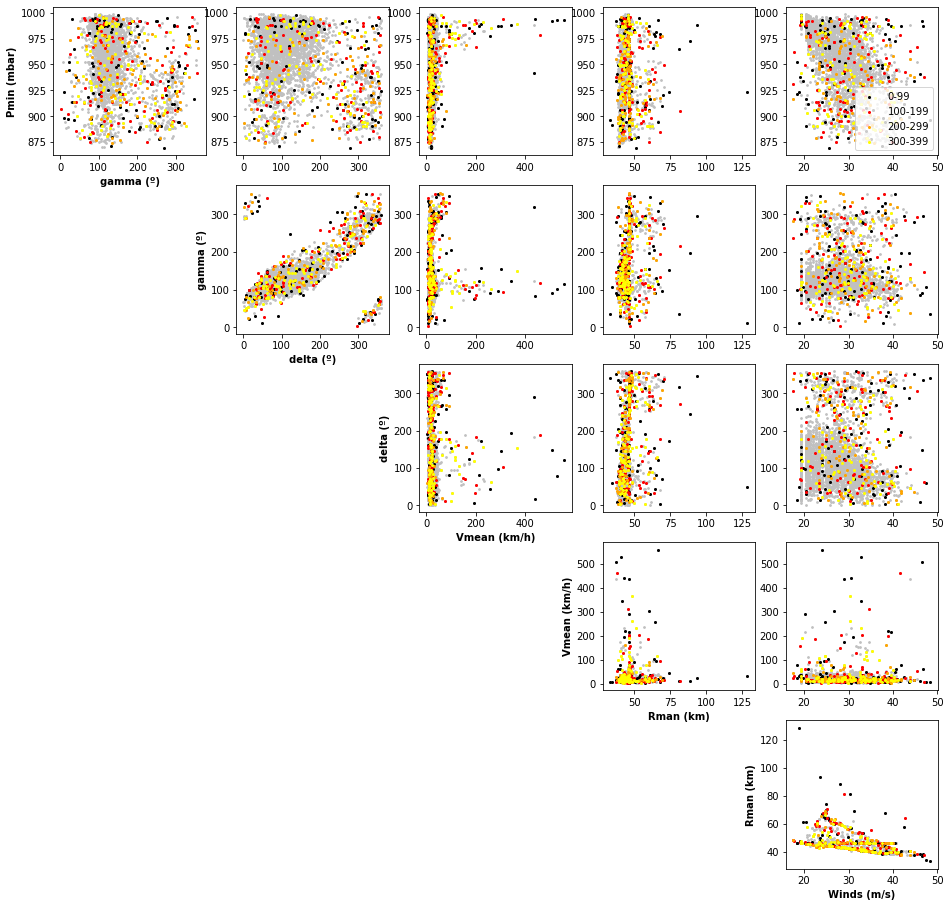

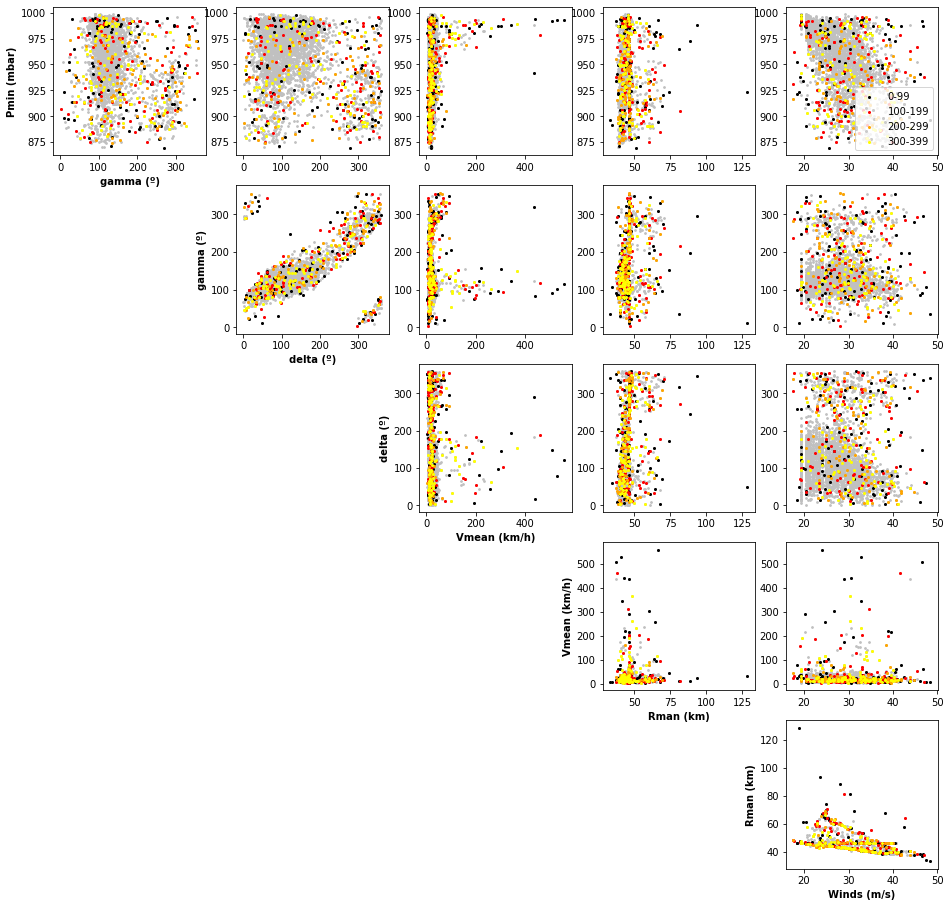

In [4]:

## MDA selection

# --------------------------------------
# MaxDiss classification

# MDA number of cases
num_sel_mda = 400

# get simulated parameters
pmean_s = TCs_r2_sim_params.pressure_mean.values[:]
pmin_s = TCs_r2_sim_params.pressure_min.values[:]
gamma_s = TCs_r2_sim_params.gamma.values[:]
delta_s = TCs_r2_sim_params.delta.values[:]
vmean_s = TCs_r2_sim_params.velocity_mean.values[:]
rmax_s = TCs_r2_sim_params.mean_radius.values[:]
winds_s = TCs_r2_sim_params.winds_mean.values[:]

# subset, scalar and directional indexes
data_mda = np.column_stack((pmean_s, pmin_s, vmean_s, rmax_s, winds_s,delta_s, gamma_s))
ix_scalar = [0,1,2,3,4]
ix_directional = [5,6]

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional
)


# store MDA storms - parameters
TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), centroids[:,0]),
        'pressure_min':(('storm'), centroids[:,1]),
        'velocity_mean':(('storm'), centroids[:,2]),
        'mean_radius':(('storm'), centroids[:,3]),
        'winds_mean':(('storm'), centroids[:,4]),
        'delta':(('storm'), centroids[:,5]),
        'gamma':(('storm'), centroids[:,6]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))
    },
)

print(TCs_r2_MDA_params)

db.Save_TCs_r2_mda_params(TCs_r2_MDA_params)

#  Simulated vs MDA selection: scatter plot parameters
Plot_TCs_Params_STORM_MDAvsSIM(TCs_r2_MDA_params, TCs_r2_sim_params)

